In [1]:
from utils import *
import cv2
import numpy as np
import matplotlib.pyplot as plt

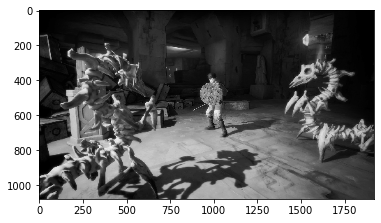

In [2]:
resample_gray = cv2.imread("resampled.png", cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(resample_gray,cmap = "gray")

In [4]:
def apply_gaussian(input_img, sigma, kernel_half):
    img = np.copy(input_img)
    width, height = img.shape[1], img.shape[0]
    window_x = (int(width/8*3), width - int(width/8*3))
    window_y = (int(height/8*3), height - int(height/8*3))
    
    kernel = gaussian_kernel(sigma,kernel_half)
    
    vertical_left = img[window_y[0]:window_y[1], window_x[0]-kernel_half:window_x[0]+kernel_half]
    vertical_right = img[window_y[0]:window_y[1], window_x[1]-kernel_half:window_x[1]+kernel_half]
    horizontal_up = img[window_y[0]-kernel_half:window_y[0]+kernel_half, window_x[0]:window_x[1]]
    horizontal_down = img[window_y[1]-kernel_half:window_y[1]+kernel_half, window_x[0]: window_x[1]]
    
    blur_vertical_left = cv2.filter2D(vertical_left, -1, kernel)
    blur_vertical_right = cv2.filter2D(vertical_right, -1, kernel)
    blur_horizontal_up = cv2.filter2D(horizontal_up, -1, kernel)
    blur_horizontal_down = cv2.filter2D(horizontal_down, -1, kernel)
    
    img[window_y[0]:window_y[1], window_x[0]-kernel_half:window_x[0]+kernel_half] = blur_vertical_left
    img[window_y[0]:window_y[1], window_x[1]-kernel_half:window_x[1]+kernel_half] = blur_vertical_right
    img[window_y[0]-kernel_half:window_y[0]+kernel_half, window_x[0]:window_x[1]] = blur_horizontal_up
    img[window_y[1]-kernel_half:window_y[1]+kernel_half, window_x[0]: window_x[1]] = blur_horizontal_down
    
    return img
    

True

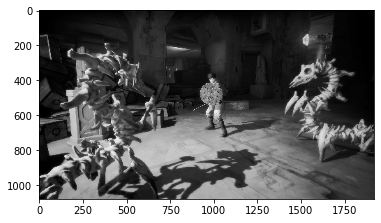

In [5]:
# modify here
sigma = 1
kernel_half = 10
new_img = apply_gaussian(resample_gray, sigma, kernel_half)
# print(np.where(new_img != resample_gray))
plt.figure()
plt.imshow(new_img,cmap="gray")
cv2.imwrite("results/gaussian_{}_{}.png".format(sigma,kernel_half),new_img)

In [6]:
from scipy import signal
def gaussian_kernel_1d(half_size, sigma):
    arr = signal.gaussian(half_size * 2 + 1, std=sigma)
    arr /= np.sum(arr)
    return arr

In [7]:
# 0 = x, 1 = y
def apply_gaussian_in_both_direction(sigma, half_size, input_img):
    kernel1 = gaussian_kernel_1d(half_size, sigma)
#     kernel2 = gaussian_kernel(sigma, half_size)
    img = np.copy(input_img)
    width, height = img.shape[1], img.shape[0]
    window_x = (int(width/8*3), width - int(width/8*3))
    window_y = (int(height/8*3), height - int(height/8*3))
    
    vertical_left = img[window_y[0]:window_y[1], window_x[0]-kernel_half:window_x[0]+kernel_half + 1]
    vertical_right = img[window_y[0]:window_y[1], window_x[1]-kernel_half:window_x[1]+kernel_half]
    horizontal_up = img[window_y[0]-kernel_half:window_y[0]+kernel_half, window_x[0]:window_x[1]]
    horizontal_down = img[window_y[1]-kernel_half:window_y[1]+kernel_half, window_x[0]: window_x[1]]
    print("kernel1 is ", kernel1, kernel1.shape)
    for i,row in enumerate(vertical_left):
        
        blur = np.convolve(row,kernel1,"same")
#         print(row, blur, row.shape)
#         print(img[i + window_y[0], window_x[0]-kernel_half:window_x[0]+kernel_half].shape)
        img[i + window_y[0], window_x[0]-kernel_half:window_x[0]+kernel_half+1] = blur
#         print()
#         print(img[i + window_y[0], window_x[0]-kernel_half-1:window_x[0]+kernel_half+2])
    
    return img

In [8]:
sigma = 0.5
kernel_half = 10
new_img = apply_gaussian_in_both_direction(sigma,kernel_half, resample_gray)

kernel1 is  [1.08853247e-87 3.46762161e-71 2.02322454e-56 2.16211377e-43
 4.23189683e-32 1.51709813e-22 9.96126165e-15 1.19794559e-08
 2.63865076e-04 1.06450769e-01 7.86570707e-01 1.06450769e-01
 2.63865076e-04 1.19794559e-08 9.96126165e-15 1.51709813e-22
 4.23189683e-32 2.16211377e-43 2.02322454e-56 3.46762161e-71
 1.08853247e-87] (21,)


In [9]:
cv2.imwrite("Gaussian_1d_{}_{}.png".format(sigma, kernel_half), new_img)

True

In [4]:
original_image = cv2.imread("EX_Chronos_screen02.jpg")

h,w,c = original_image.shape
resample_whole = cv2.resize(original_image, (w//4,h//4))
resample_whole = cv2.resize(resample_whole, (w, h))

A = original_image
B = resample_whole

m = np.zeros_like(A, dtype='float32')
m[405:675,720:1200,:] = 1.0


In [6]:
num_levels = 5

GA = A.copy()
GB = B.copy()
GM = m.copy()
gaussian_p_A = [GA]
gaussian_p_B = [GB]
gaussian_p_M = [GM]

for i in range(num_levels):
    GA = cv2.pyrDown(GA)
    GB = cv2.pyrDown(GB)
    GM = cv2.pyrDown(GM)
    gaussian_p_A.append(np.float32(GA))
    gaussian_p_B.append(np.float32(GB))
    gaussian_p_M.append(np.float32(GM))

# generate Laplacian Pyramids for A,B and masks
laplacian_A  = [gaussian_p_A[num_levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
laplacian_B  = [gaussian_p_B[num_levels-1]]
gaussian_mask = [gaussian_p_M[num_levels-1]]
for i in range(num_levels-1,0,-1):

    LA = np.subtract(gaussian_p_A[i-1], cv2.pyrUp(gaussian_p_A[i], dstsize =(gaussian_p_A[i-1].shape[1], gaussian_p_A[i-1].shape[0])))
    LB = np.subtract(gaussian_p_B[i-1], cv2.pyrUp(gaussian_p_B[i], dstsize =(gaussian_p_B[i-1].shape[1], gaussian_p_B[i-1].shape[0])))
    laplacian_A.append(LA)
    laplacian_B.append(LB)
    gaussian_mask.append(gaussian_p_M[i-1]) # also reverse the masks

# Now blend images according to mask in each level
LS = []
for la,lb,gm in zip(laplacian_A,laplacian_B,gaussian_mask):
    ls = la * gm + lb * (1.0 - gm)
    LS.append(ls)

# now reconstruct
ls_ = LS[0]
for i in range(1,5):
    ls_ = cv2.pyrUp(ls_, dstsize=(LS[i].shape[1],LS[i].shape[0]))
    ls_ = cv2.add(ls_, LS[i])


In [7]:
cv2.imwrite("laplacian_pyramid.jpg", ls_)

True